In [1]:
from significance_of_mean_cuda import significance_of_mean_cuda
import pandas as pd
import numpy as np
import time
from scipy.stats import mannwhitneyu, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [2]:
%load_ext cython
%load_ext rpy2.ipython



R[write to console]: Warning:
R[write to console]:  namespace ‘pbdZMQ’ is not available and has been replaced
by .GlobalEnv when processing object ‘.pbd_env’

/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [3]:
%%R

require(ggplot2)
install.packages("devtools")
library("devtools")
install_github("bdsegal/fastPerm")

library(fastPerm)

R[write to console]: Loading required package: ggplot2

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/devtools_2.2.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 375464 bytes (366 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

In [4]:
%%R
    runFastPerm <- function(x,y,output, n_samples) {
        e <- list(mode="vector",length=n_samples)
        for (i in 1:n_samples) {
      
            mStopDiffMean(x[[i]], y[[i]])
            valX = fastPerm(x[[i]], y[[i]], testStat = diffMean)
            
            valX <-unlist(valX)

      
            output[[i]] <- as.numeric(valX[1])
      
            }
    

    return(output)


    }

In [5]:
def fastPerm(A,B):
    x = pd.DataFrame(A, columns=list(range(A.shape[1]))).T
    y = pd.DataFrame(B, columns=list(range(B.shape[1]))).T
    n_samples = x.shape[1]
    outputDf = pd.DataFrame(n_samples * [0], columns=["output"]).T
    
    %R -i x
    %R -i y
    %R -i outputDf
    %R -i n_samples
    
    
    %R out <- runFastPerm(x,y, outputDf, n_samples)
    
    
    %R -o out
    return list(out.T["output"].values)

In [6]:
def exactTest(A,B, bins=10, one_side=False):
    SGM = significance_of_mean_cuda(bins, dtype_v=np.uint32,dtype_A=np.float64, )
    SGM.run(np.asarray(A),np.asarray(B), midP=True)
    if one_side:
        return SGM.get_p_values()
    else:
        return [2 * min( p, (1-p)) for p in SGM.get_p_values()]

def MWU(A, B, one_side=False):
    p_mw = list()
    for a,b in zip(A, B):
        if one_side:
            p_mw.append(mannwhitneyu(a,b, alternative="less")[1])
        else:
            p_mw.append(mannwhitneyu(a,b, alternative="two-sided")[1])
    return p_mw

def ttests(A,B, one_side=False):
    p_t = list()
    for x, y in zip(A, B):
        t, p = ttest_ind(y, x)
        if one_side:
            p = p/2
            if t<0:
                p = 1-p
        p_t.append(p)
    return p_t


In [7]:
def getPrediction(A,B):
    Data = dict()
    
    Data["eList"] = exactTest(B, A, 35, False)
    
    print(  Data["eList"])
    Data["fpList"] = fastPerm(np.array(A),np.array(B))
    Data["mwuList"] = MWU(A, B, False)
    Data["ttList"] = ttests(A, B, False)
    print(  Data["ttList"])
    return Data

In [8]:
def getSynteticData(func, setN=20, sampleN=2_000, mean=0, std=1,seed=1):
    np.random.seed(seed)
    AN, BN = [func(mean,std,setN) for i in range(sampleN)], [func(0,std,setN) for i in range(sampleN)]
    return AN, BN

In [9]:
def relError(Data):
    pe_list = Data["eList"] 
    p_fp_list = Data["fpList"] 
    pmw_list = Data["mwuList"] 
    pt_list = Data["ttList"]
    
    errorDict = dict()
    errorDict["eList"] = list()
    errorDict["fpList"] = list()
    errorDict["mwuList"] = list()
    for P_fp, P_e, P_t, P_mw in zip(p_fp_list, pe_list, pt_list, pmw_list):
        print(P_fp)
        print(P_e)
        print(P_t)
        print(P_mw)
        errorDict["fpList"].append((P_fp - P_t) / P_t)
        errorDict["eList"].append((P_e - P_t) / P_t)
        errorDict["mwuList"].append((P_mw - P_t) / P_t)
    return errorDict
        

In [577]:
def preparePandas(timeData, sampleSizes,label=None):
    preparePd = list()
    for time, sample in zip(timeData, sampleSizes):
        for t in time:
            if label:
                preparePd.append([t, sample, label])
            else:
                preparePd.append([t, sample])
    return preparePd

def SNSMultipleboxPlot(allEerrorList, Bin, allMWUList=None, allFPList=None, log=True, 
                       path=None, test_type="setSize", relError=True, dashed=False,
                       ylim=False):
    
    plt.figure(figsize=(16, 10))
    
    dataParallel = preparePandas(allEerrorList, Bin, "Parallel shift")
    
    data= dataParallel
    
    if allFPList:
        dataFastApprox = preparePandas(allFPList, Bin, "FastPerm")
        data += dataFastApprox
    if allMWUList:
        MannWhitneyApprox = preparePandas(allMWUList, Bin, "Mann–Whitney U-test")
        data += MannWhitneyApprox
    
    sns.set(style="white")
    sns.set_context("talk")
    
    pdData = pd.DataFrame(data, columns=['error','bins', 'Method'])
    
    if test_type=="setSize":
        snsPlot = sns.boxplot(x="bins", y="error", data=pdData, hue="Method")
    else:
        snsPlot = sns.boxplot(x="bins", y="error", data=pdData, color="skyblue")
        
    
    if relError:
        plt.ylabel(r"Relative error $\big(|\frac{p_{*}-p_{t}}{p_{t}}|)$",fontsize=25)
    else:
        plt.ylabel(r"$\frac{p_{*}}{p_{t}}$",fontsize=45)
        
    if test_type=="windowSize":
        plt.xlabel(r"$n_{w}$",fontsize=65)
    else:
        plt.xlabel(r"$n$",fontsize=65)
    
    sns.set_style("ticks")
    sns.despine()
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.30)
    
    
    
    

    
    
    
    if log:
        if allFPList and allMWUList:
            MAX = max(np.max(allEerrorList), np.max(allFPList), np.max(allMWUList))
            MIN = min(np.min(allEerrorList), np.min(allFPList), np.min(allMWUList))
        elif allFPList:
            MAX = max(np.max(allEerrorList), np.max(allFPList))
            MIN = min(np.min(allEerrorList), np.min(allFPList))
        elif allMWUList:
            MAX = max(np.max(allEerrorList), np.max(allMWUList))
            MIN = min(np.min(allEerrorList), np.min(allMWUList))
        else:
            MAX = np.max(allEerrorList)
            MIN = np.min(allEerrorList)
         

        if dashed:
            plt.axhline(0, ls=':', color="black", linewidth=3)
        
            
        #RANGE = np.arange(np.floor(MIN), np.ceil(MAX), 100)
        RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
        
        if not relError:
            if ylim:
                RANGE = np.array(sorted(list(RANGE) + [np.log10(0.5), np.log10(2)]))
            else:
                RANGE = np.array(sorted(list(RANGE)))

        plt.yticks(RANGE, 10.0**RANGE)

        
        
    if test_type=="setSize":
        plt.legend().set_title('')
    
    #€plt.yticks([0.5, 1, 2])
    
    
    if ylim:
        plt.ylim(np.log10(ylim[0]) ,np.log10(ylim[1]))
        
        plt.xticks(size = 40)
        plt.yticks(size = 50)
    else:
        plt.xticks(size = 40)
        plt.yticks(size = 25)
        
    

    
    if path:
        fig = snsPlot.get_figure()
        fig.savefig(path)

In [348]:
setSize = [10,50,100,150,200,250,300]

In [417]:
allEerrorList1, allFracList1 = list(), list()
allMWUList1, allFracMWUList1 = list(), list()
allFPList1, allFracFPList1 = list(), list()
for setS in setSize:
    Anorm0, Bnorm0 = getSynteticData(np.random.normal, mean=0.2, setN=setS,sampleN=50)
    ptTest  = ttests(Anorm0, Bnorm0)
    
    peList = exactTest(Anorm0, Bnorm0, bins=30)
    ExactErrorList = getErrors(peList, ptTest)
    ExactFracList = getErrors(peList, ptTest, False) 
    allEerrorList1.append(np.log10(np.abs(ExactErrorList)))
    allFracList1.append(np.log10(ExactFracList))
    
    pmwList = MWU(Anorm0, Bnorm0)
    MWUErrorList = getErrors(pmwList, ptTest)
    MWUFracList = getErrors(pmwList, ptTest, False) 
    allFracMWUList1.append(np.log10(MWUFracList))
    allMWUList1.append(np.log10(np.abs(MWUErrorList)))
    

    ptfp = fastPerm(np.array(Anorm0), np.array(Bnorm0))
    FPErrorList = getErrors(ptfp, ptTest)
    FPFracList = getErrors(ptfp, ptTest, False)
    allFPList1.append(np.log10(np.abs(FPErrorList)))
    allFracFPList1.append(np.log10(FPFracList))

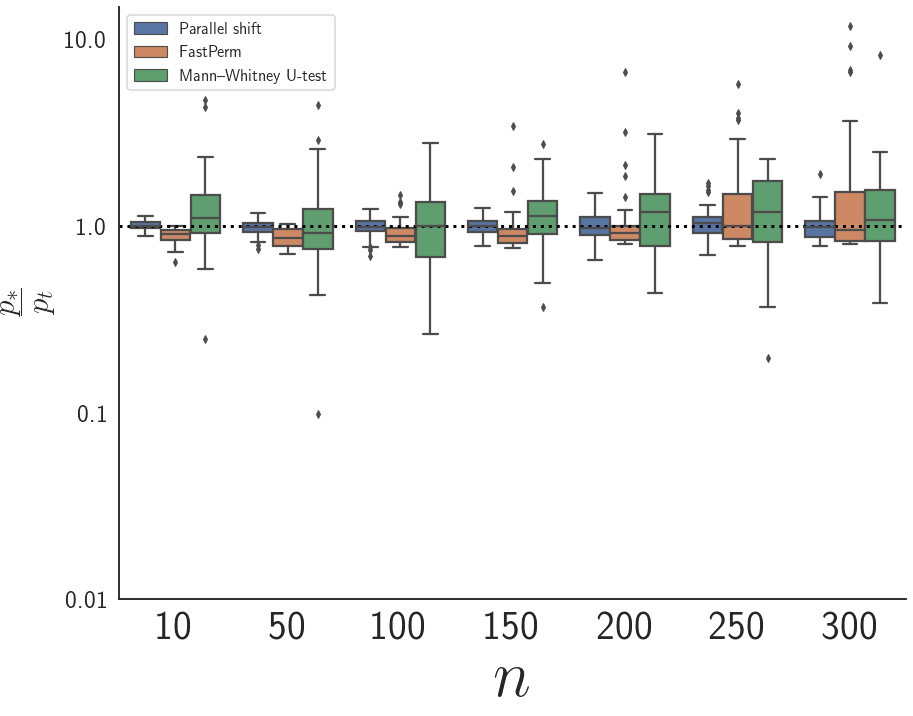

In [578]:
SNSMultipleboxPlot(allFracList1, setSize, allFracMWUList1, 
                   allFracFPList1, 
                   relError=False,
                   path="./figures/accuracy/mean_1",
                  dashed=True)

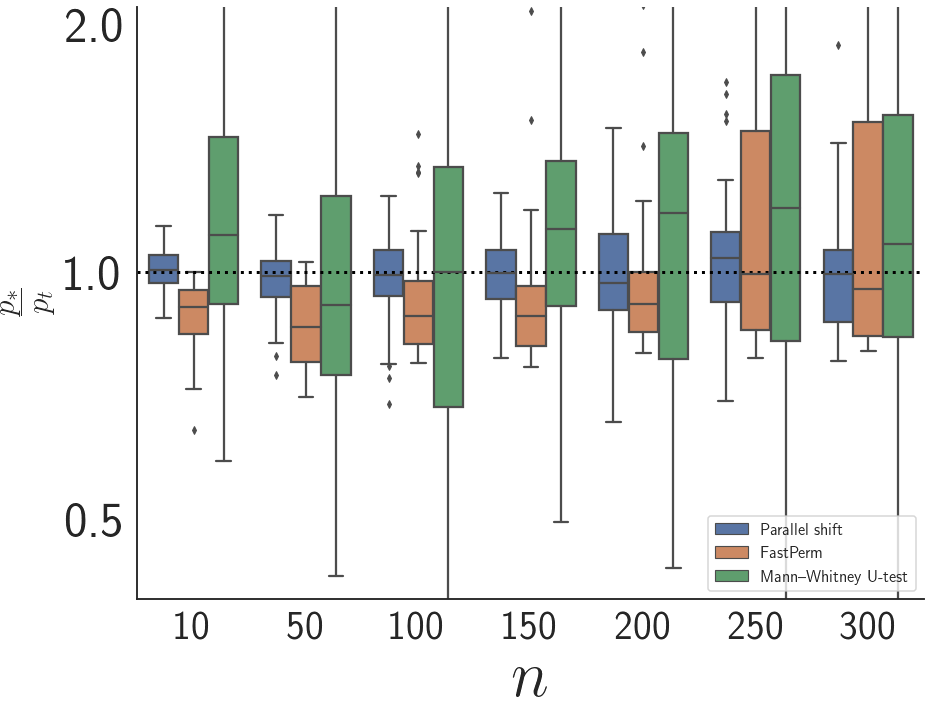

In [579]:
SNSMultipleboxPlot(allFracList1, setSize, allFracMWUList1, 
                   allFracFPList1, 
                   relError=False,
                   path="./figures/accuracy/mean_1",
                  dashed=True,ylim=[0.4, 2.1])

In [421]:
allEerrorList2, allFracList2 = list(), list()
allMWUList2, allFracMWUList2 = list(), list()
allFPList2, allFracFPList2 = list(), list()
for setS in setSize:
    Anorm0, Bnorm0 = getSynteticData(np.random.normal, mean=1.0, setN=setS,sampleN=50)
    ptTest  = ttests(Anorm0, Bnorm0)
    
    peList = exactTest(Anorm0, Bnorm0, bins=30)
    ExactErrorList = getErrors(peList, ptTest)
    ExactFracList = getErrors(peList, ptTest, False) 
    allEerrorList2.append(np.log10(np.abs(ExactErrorList)))
    allFracList2.append(np.log10(ExactFracList))
    
    pmwList = MWU(Anorm0, Bnorm0)
    MWUErrorList = getErrors(pmwList, ptTest)
    MWUFracList = getErrors(pmwList, ptTest, False) 
    allFracMWUList2.append(np.log10(MWUFracList))
    allMWUList2.append(np.log10(np.abs(MWUErrorList)))
    
    
    
    ptfp = fastPerm(np.array(Anorm0), np.array(Bnorm0))
    FPErrorList = getErrors(ptfp, ptTest)
    FPFracList = getErrors(ptfp, ptTest, False)
    allFPList2.append(np.log10(np.abs(FPErrorList)))
    allFracFPList2.append(np.log10(FPFracList))

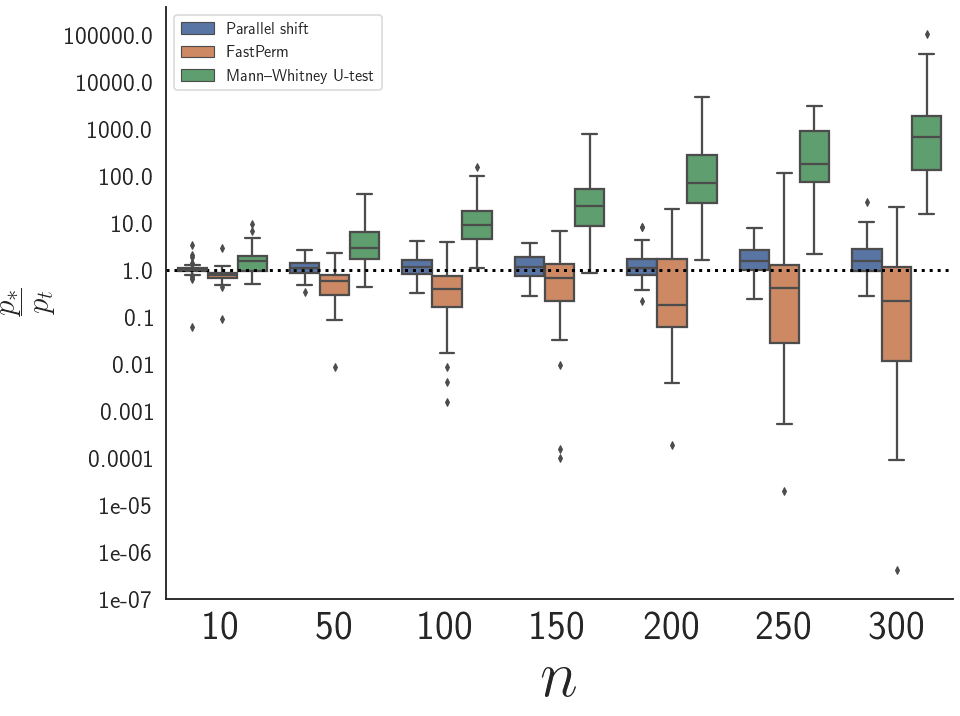

In [580]:
SNSMultipleboxPlot(allFracList2, setSize, allFracMWUList2, 
                   allFracFPList2, relError=False,path="./figures/accuracy/mean_1", dashed=True)



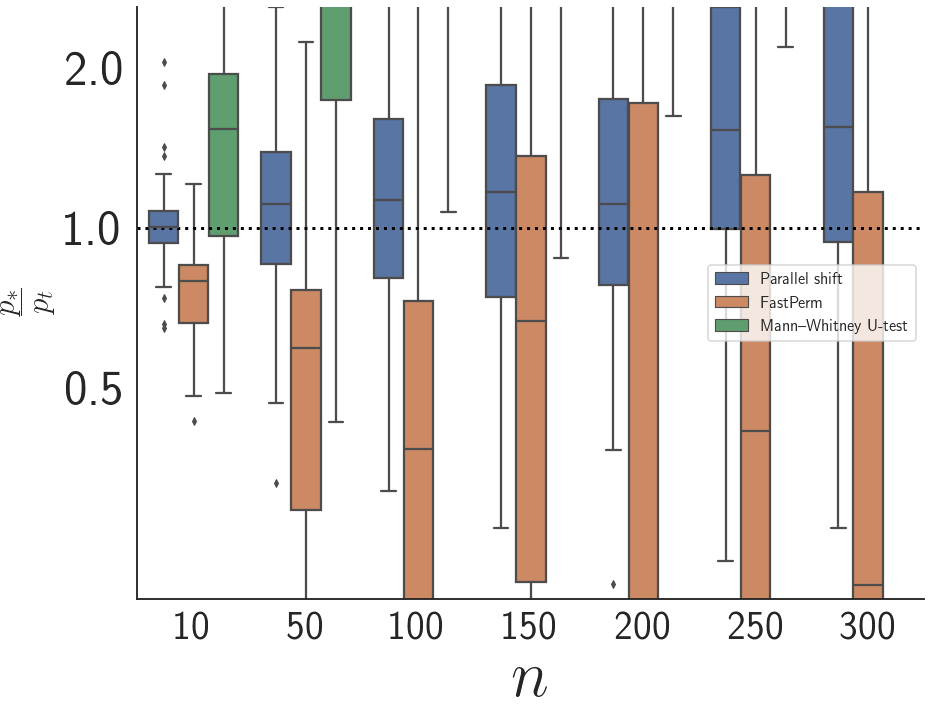

In [581]:
SNSMultipleboxPlot(allFracList2, setSize, allFracMWUList2, 
                   allFracFPList2, relError=False,path="./figures/accuracy/mean_1", 
                   dashed=True, ylim=[0.2, 2.6])



In [14]:
N_w = list(range(10, 101,4))

In [ ]:
d


In [430]:
def getNwPlot(setSize):
    N_w = list(range(5, 105,5))
    allEerrorNw, allEerrorNwFrac = list(), list()
    for n_w in N_w:
        Anorm0, Bnorm0 = getSynteticData(np.random.normal, mean=1.0, setN=setSize,sampleN=50)
        ptTest  = ttests(Anorm0, Bnorm0)
    
        peList = exactTest(Anorm0, Bnorm0, bins=n_w)
        ExactErrorList = getErrors(peList, ptTest)
        ExactFracList = getErrors(peList, ptTest, False) 
        allEerrorNw.append(np.log10(np.abs(ExactErrorList)))
        allEerrorNwFrac.append(np.log10(ExactFracList))
    return allEerrorNwFrac, N_w
    
    

# |A|=|B|=10

In [431]:
n0 = setSize[0]; n0

10

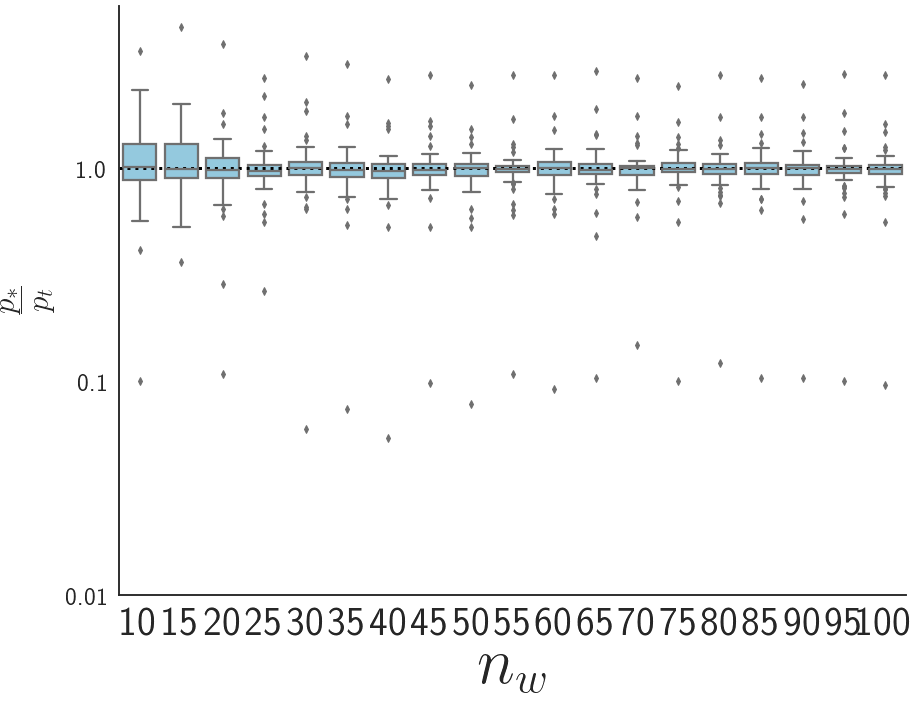

In [582]:
#allEerrorNwFrac0, N_w = getNwPlot(n0)
SNSMultipleboxPlot(allEerrorNwFrac0[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True)

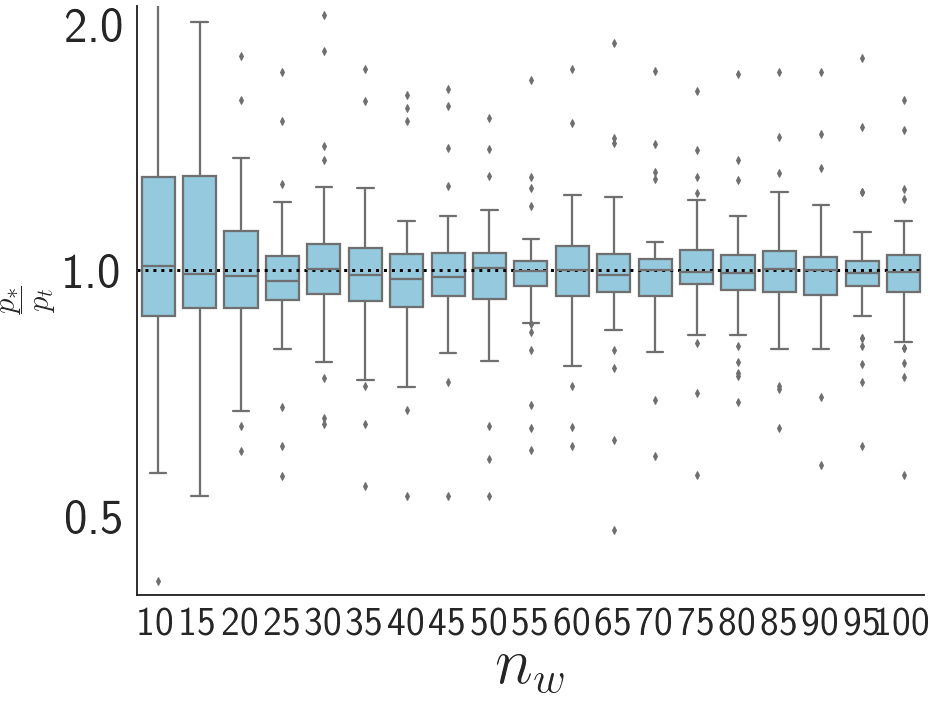

In [583]:

SNSMultipleboxPlot(allEerrorNwFrac0[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=50

In [542]:
n1 = setSize[1]; n1

50

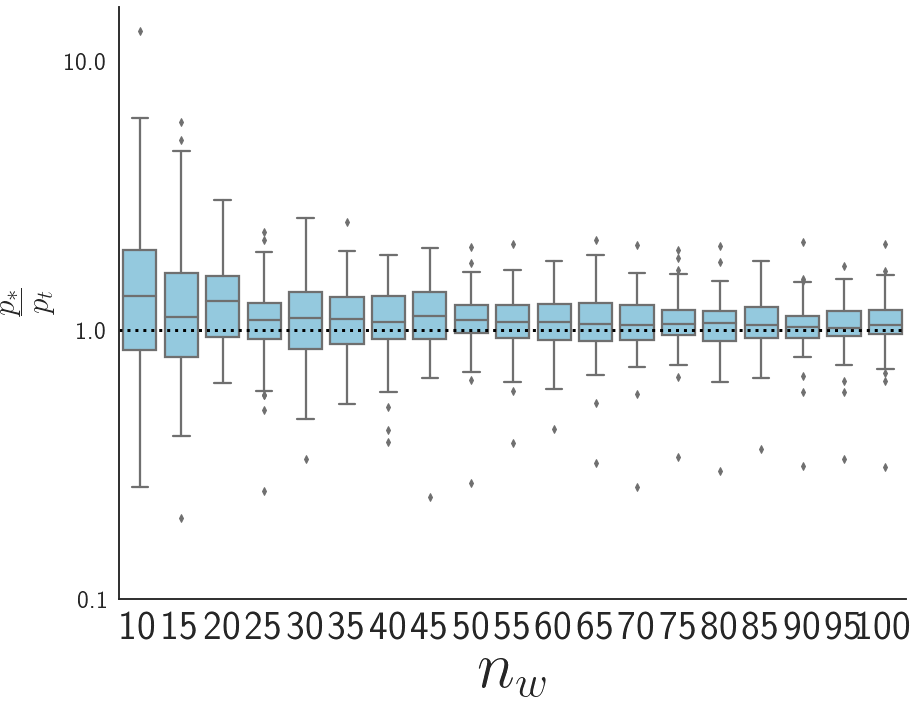

In [584]:
#allEerrorNwFrac1, N_w = getNwPlot(n1)
SNSMultipleboxPlot(allEerrorNwFrac1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True)

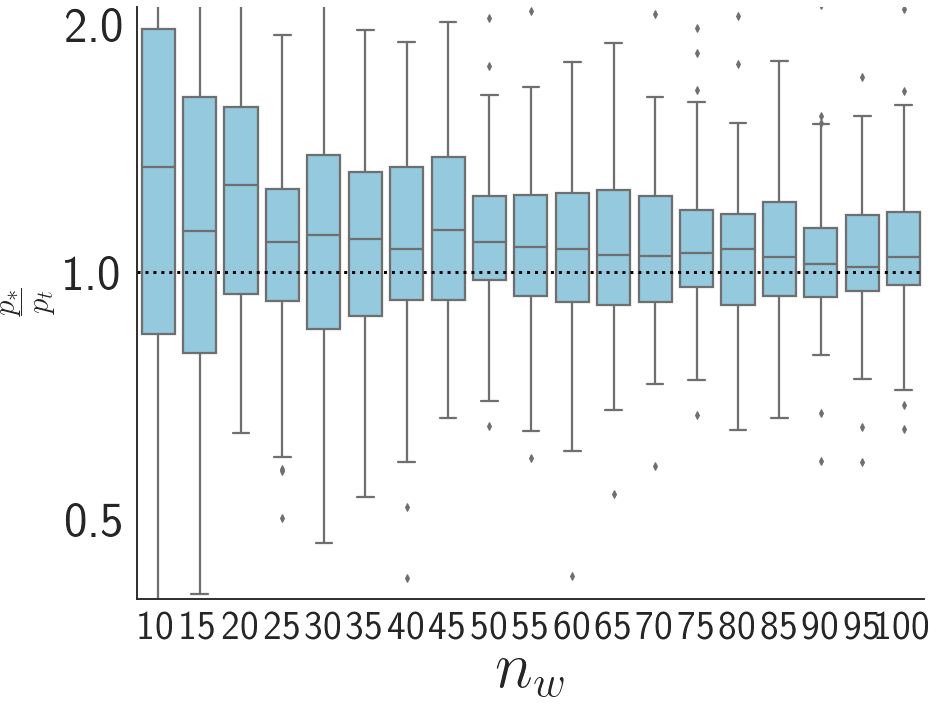

In [585]:
SNSMultipleboxPlot(allEerrorNwFrac1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=100

In [545]:
n2 = setSize[2]; n2

100

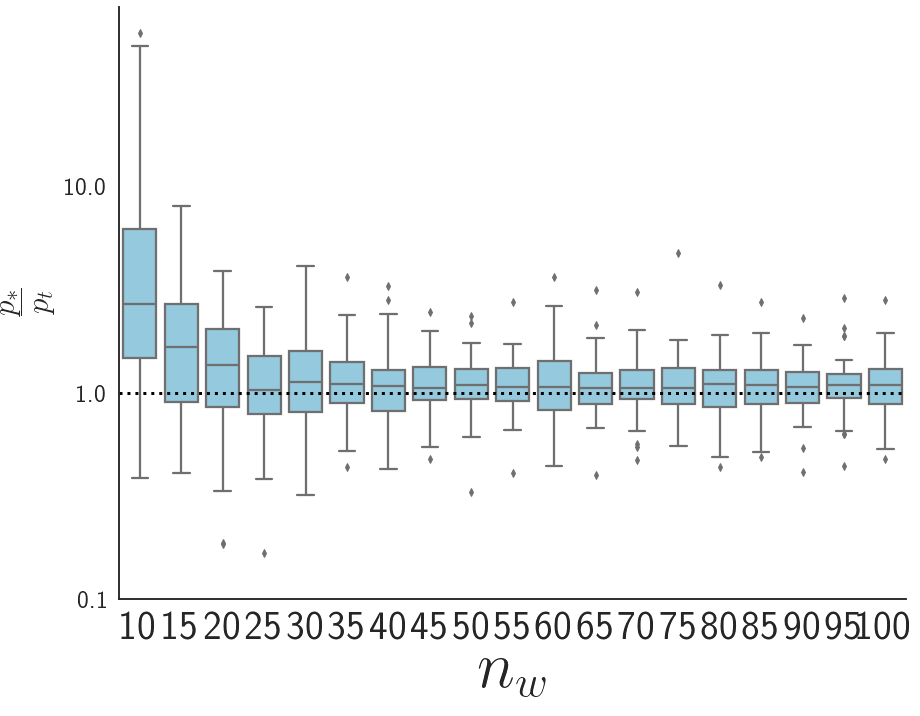

In [586]:
#allEerrorNwFrac2, N_w = getNwPlot(n2)
SNSMultipleboxPlot(allEerrorNwFrac2[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True)

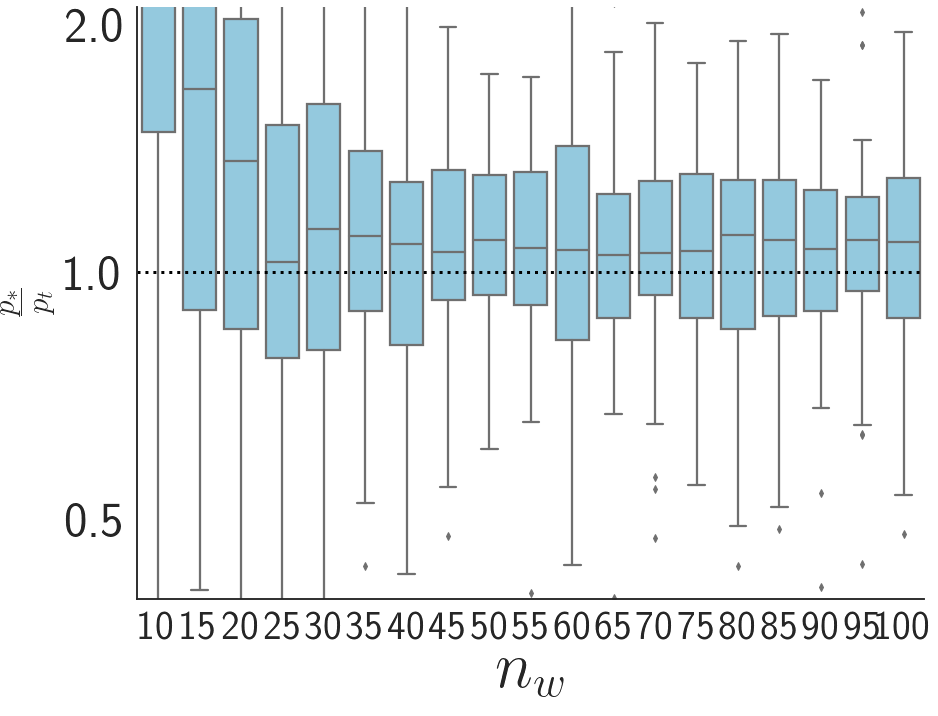

In [588]:

SNSMultipleboxPlot(allEerrorNwFrac2[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=150

In [548]:
n3 = setSize[3]; n3

150

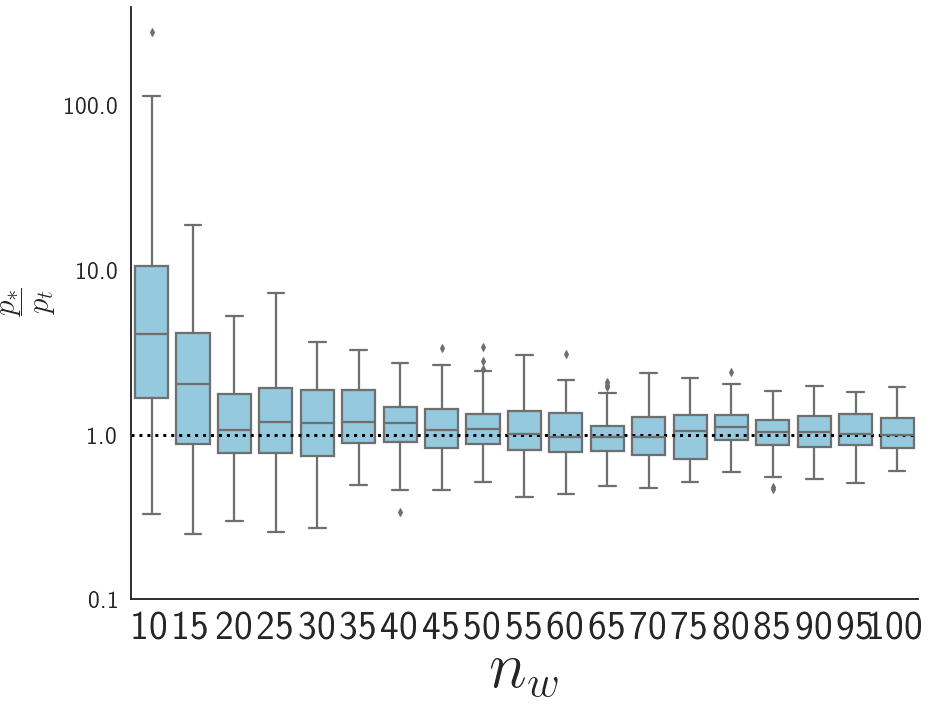

In [589]:
#allEerrorNwFrac3, N_w = getNwPlot(n3)

SNSMultipleboxPlot(allEerrorNwFrac3[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True)

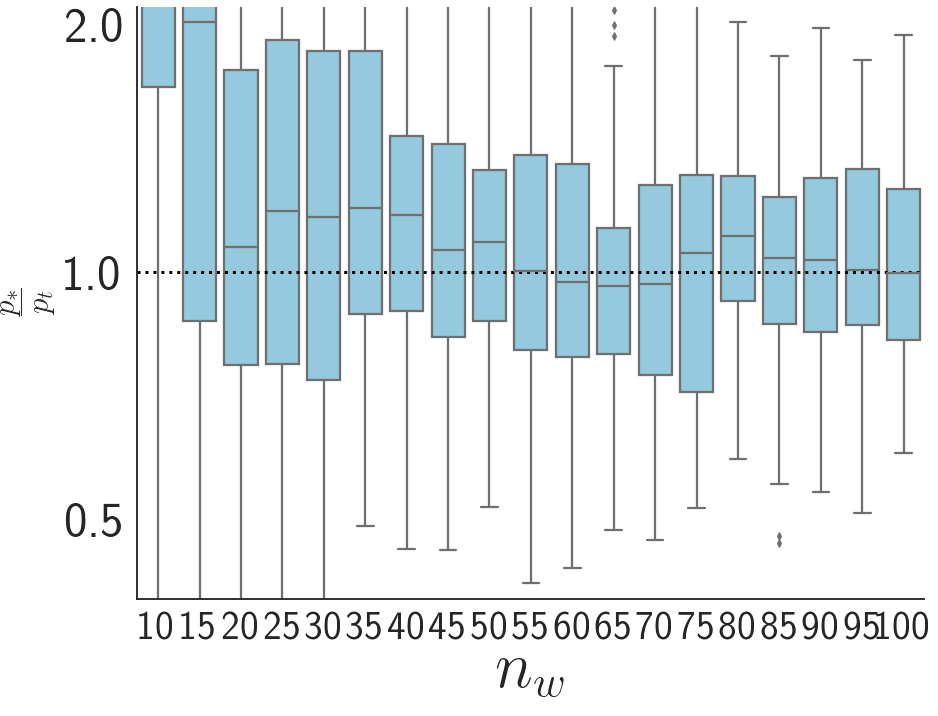

In [590]:
SNSMultipleboxPlot(allEerrorNwFrac3[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=200

In [551]:
n4 = setSize[4]; n4

200

In [552]:
#allEerrorNwFrac4, N_w = getNwPlot(n4)

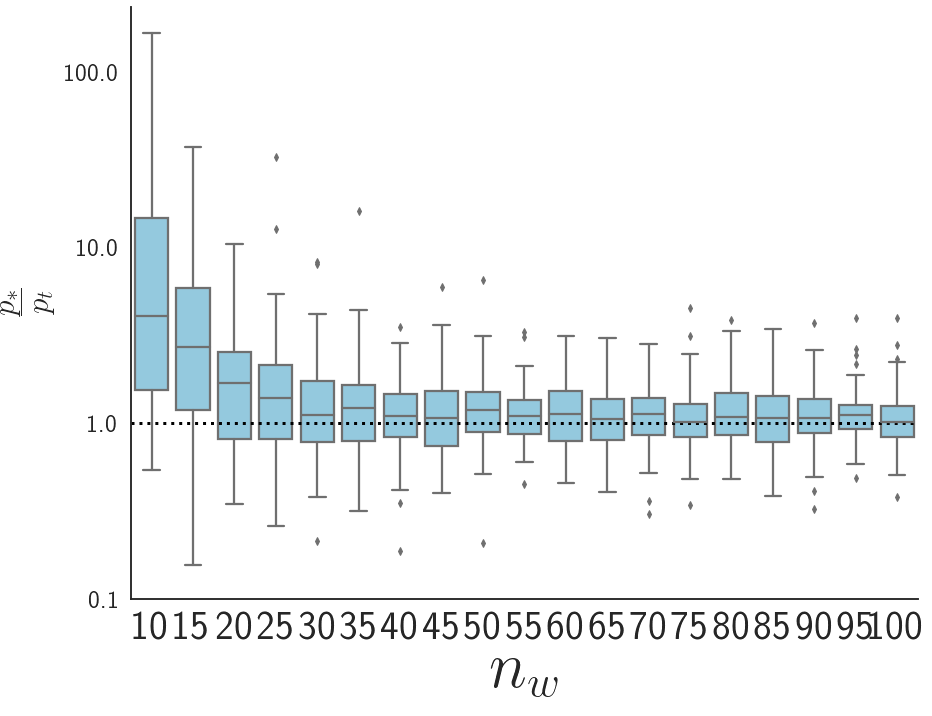

In [591]:
SNSMultipleboxPlot(allEerrorNwFrac4[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True)

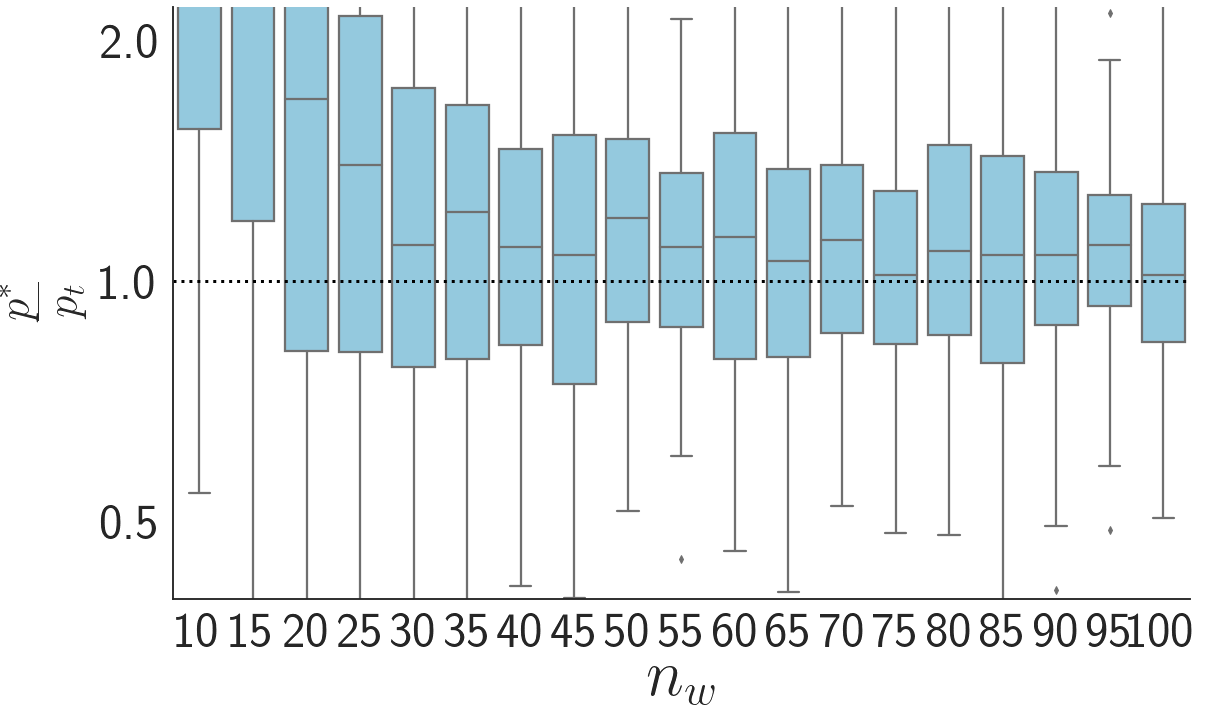

In [554]:
SNSMultipleboxPlot(allEerrorNwFrac4[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True, ylim=[0.4, 2.2])

# |A|=|B|=250


In [555]:
n5 = setSize[5]; n5

250

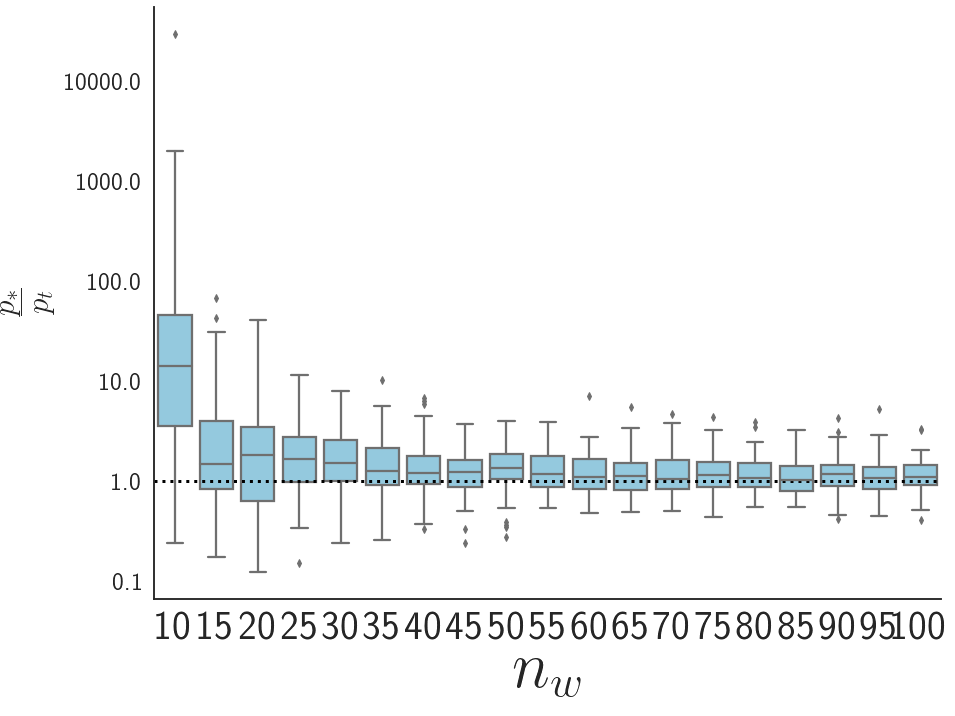

In [592]:
#allEerrorNwFrac5, N_w = getNwPlot(n5)
SNSMultipleboxPlot(allEerrorNwFrac5[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True)

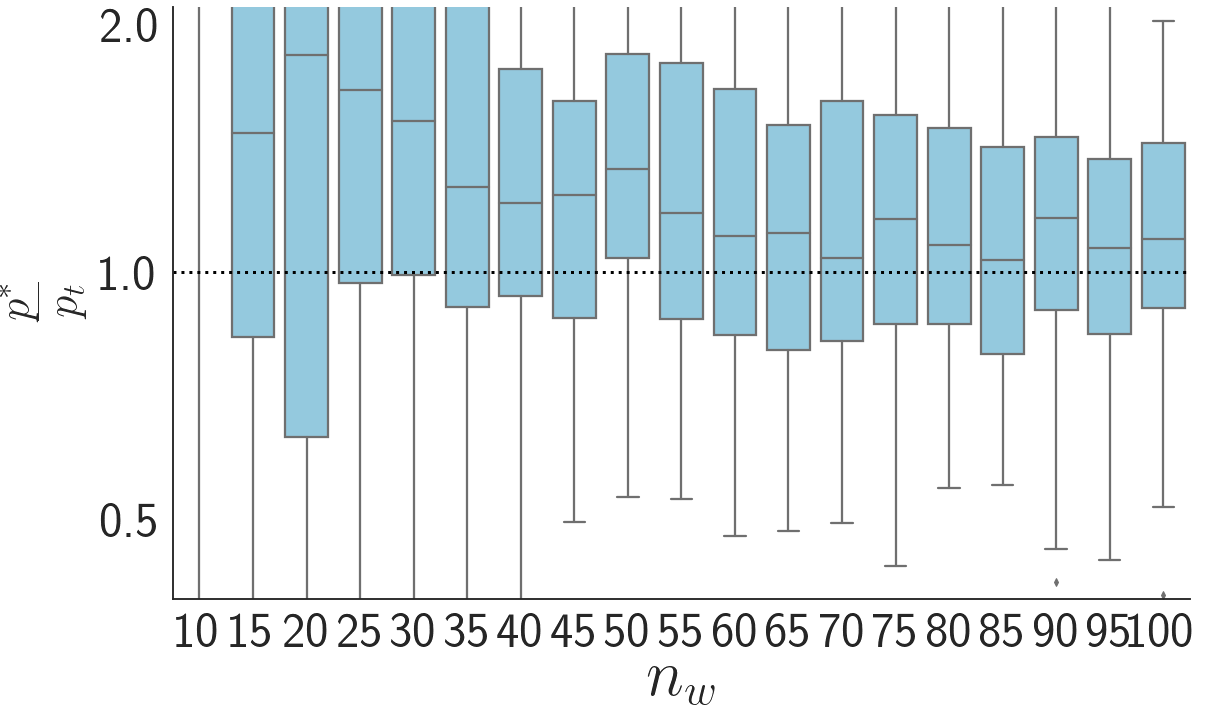

In [557]:
SNSMultipleboxPlot(allEerrorNwFrac5[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=250


In [558]:
n6 = setSize[6];n6

300

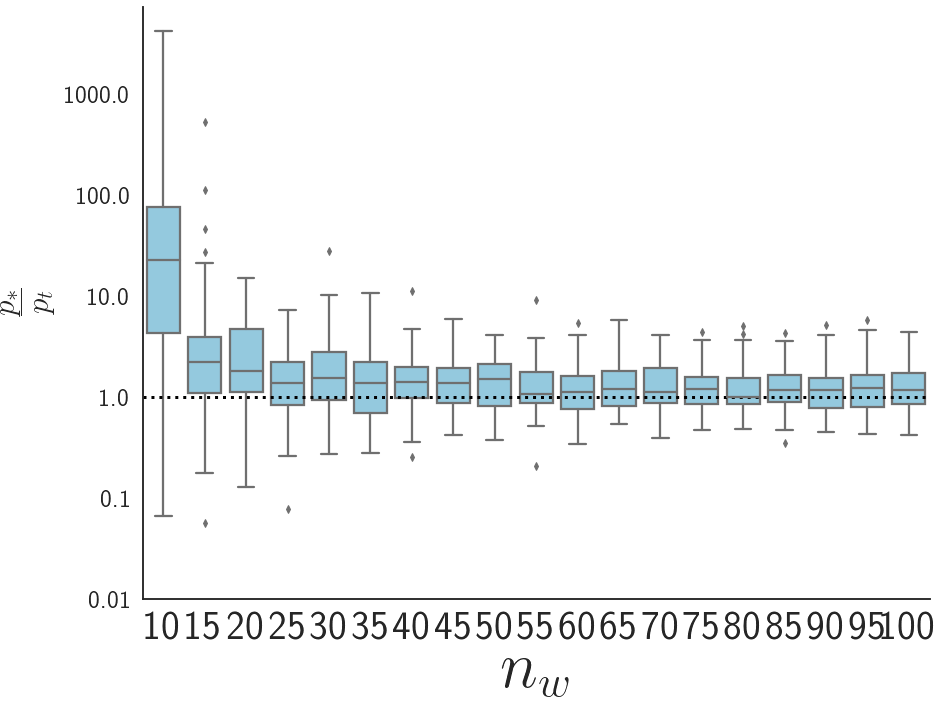

In [593]:
#allEerrorNwFrac6, N_w = getNwPlot(n6)
SNSMultipleboxPlot(allEerrorNwFrac6[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True,
                  )

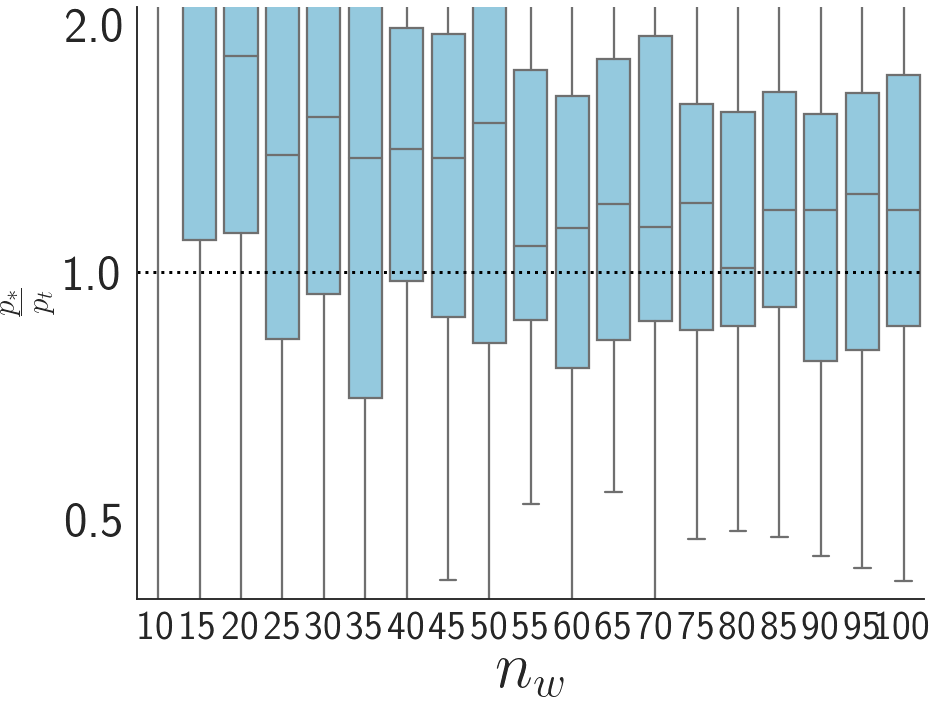

In [594]:
SNSMultipleboxPlot(allEerrorNwFrac6[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize",
                  dashed=True,ylim=[0.4, 2.1]
                  )

In [ ]:
peList = exactTest(Anorm0, Bnorm0, bins=30)
pmwList = MWU(Anorm0, Bnorm0)
ptTest  = ttests(Anorm0, Bnorm0)
ptfp = fastPerm(np.array(Anorm0), np.array(Bnorm0))

In [12]:
def getErrors(pValList, pTtestList, rel=True):
    relatvieErrorList = list()
    for pv, pt in zip(pValList, pTtestList):
        if rel:
            relatvieErrorList.append(relError(pv, pt))
        else:
            relatvieErrorList.append(frac(pv, pt))
            
    return relatvieErrorList

def relError(x,y):
    return frac((x - y), y) 
def frac(x,y):
    return x / y
    
        

In [13]:
def predictAndAnalyze():
    peList = exactTest(Anorm0, Bnorm0, bins=30)
    

In [15]:
errorDictList = list()
for setS in setSize:
    Anorm0, Bnorm0 = getSynteticData(np.random.normal, mean=0.2, setN=setS,sampleN=50)
    %time dataDict = getPrediction(Anorm0, Bnorm0)
    errorDict = relError(dataDict)
    errorDictList.append(errorDict)

[0.3368875706337007, 0.7387852085994501, 0.250763168719825, 0.8111509233800251, 0.10291411375002713, 0.2944911126025678, 0.7543895732750221, 0.3698932646301067, 0.29903764965684454, 0.3909913615795969, 0.12585788824178934, 0.8349661174738574, 0.3485137153867808, 0.38918898439022276, 0.05134880599276892, 0.6079261295979563, 0.23040659031371136, 0.1632260927926561, 0.9610729827448095, 0.019371495377687564, 0.9364080192253569, 0.5746552209400506, 0.16730173850916863, 0.7816687956006845, 0.5843220247245016, 0.6900668990452272, 0.3764153802853496, 0.21841780510511177, 0.497510229708372, 0.48971075364264194, 0.8216891467665461, 0.24867392669250243, 0.23867695771720543, 0.12038580614432007, 0.7398081794366624, 0.2951352053519236, 0.6461657537508929, 0.8486815042542597, 0.7377351750416766, 0.1041752365281774, 0.6365097750546668, 0.7803697850137479, 0.38227716555889923, 0.04107579726774757, 0.934892506873931, 0.6526878694061357, 0.022775985624282624, 0.44990149169715754, 0.07730736755504553, 0.

TypeError: relError() missing 1 required positional argument: 'y'

In [ ]:
SNSMultipleboxPlot(errorDictList, setSize)

In [ ]:
errorDictList = list()
for setS in setSize:
    Anorm1, Bnorm1 = getSynteticData(np.random.normal, mean=5.1, setN=setS,sampleN=50)
    %time dataDict = getPrediction(Anorm1, Bnorm1)
    errorDict = relError(dataDict)
    errorDictList.append(errorDict)

In [ ]:
SNSMultipleboxPlot(errorDictList, setSize)

In [ ]:
[error["fpList"] for error in errorDictList]

In [ ]:
preparePandas([error["eList"] for error in errorDictList], setSize)

In [ ]:
errorDictList = list()
for setS in setSize:
    Anorm, Bnorm = getSynteticData(np.random.normal, mean=0, setN=setS,sampleN=50)
    %time dataDict = getPrediction(Anorm, Bnorm)
    errorDict = relError(dataDict)
    errorDictList.append(errorDict)

In [ ]:
preparePandas([error["eList"] for error in errorDictList], setSize)

In [ ]:
errorDict

In [ ]:
from significance_of_mean_cuda import significance_of_mean_cuda
from utils import significance_of_mean, getdf, my_scatter_plot, ttests, MW
import numpy as np
import time
import multiprocessing
import concurrent.futures as cf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from IPython.display import Image

import time
from scipy.stats import ttest_ind, ttest_rel, chisquare, ks_2samp
import pandas as pd
import seaborn as sns

import matplotlib as mpl

mpl.rcParams['text.usetex'] = False  # not really needed

from scipy import stats
from scipy.stats import mannwhitneyu

In [ ]:
def p_value_calc(args):
    a,b, bins = args
    p=significance_of_mean(a,b, bins)[0]
    return p

### Load data from MC approximation of permutation test

In [ ]:
def loadMcResult(sampleShape, mean):
    X_list = list()
    y_list = list()
    p_val_list = list()
    time_listMc = list()
    for S in sampleShape:
        X = pd.read_csv("dataFastPerm/data_{}/X_{}.csv".format(mean, S))
        Y = pd.read_csv("dataFastPerm/data_{}/y_{}.csv".format(mean, S))
        p_val = pd.read_csv("dataFastPerm/data_{}/error_{}.csv".format(mean, S))
        timeMc = pd.read_csv("dataFastPerm/data_{}/Time_{}.csv".format(mean, S))
    
    
        X.columns = range(X.shape[1])
        Y.columns = range(Y.shape[1])
        p_val.columns = range(p_val.shape[1])
        timeMc.columns = range(timeMc.shape[1])
    
    
        X_list.append([np.array(x.split(" ")[1:]).astype(float) for x in X[0].values])
        y_list.append([np.array(y.split(" ")[1:]).astype(float) for y in Y[0].values])
        p_val_list.append(np.array([float(p[0].split(" ")[1]) for p in p_val.values]))
        time_listMc.append([float(t[0].split(" ")[1]) for t in timeMc.values])
    
    return X_list, y_list, p_val_list, time_listMc

### Get p-value for the the parallelized permutation test

In [ ]:
def run_test(X,Y,bins, parallel=True, midP=False):

    
    
    if parallel:
        #Exact test
        SGM = significance_of_mean_cuda(bins, dtype_v=np.uint32,dtype_A=np.float64)
        SGM.run(X.reshape(1,-1),Y.reshape(1,-1), midP)
        p_val = SGM.p_values[0]
    else:
        p_val = p_value_calc([list(X), list(Y), bins])
    #print(p_val)
    #p_val = [min(2*p, 2*(1-p)) for p in p_val]
    return p_val

### Get all p-values from the prallelized exact test from the same data as the MC version

In [ ]:
def shiftMethod(X_list, y_list, bins, parallel=True, midP=False):
    pe_list = list()
    TIME = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_e = list()
        time_list = list()
    
        for x, y in zip(Xp, yp):
            
            start = time.time()
            p_e.append(run_test(y, x, bins, parallel, midP))
            end = time.time()
        
            time_list.append(end - start)
        p_e = [min(2*p, 2*(1-p)) for p in p_e]
        pe_list.append(p_e)
        TIME.append(time_list)
    
    return pe_list, TIME
    

In [ ]:
def ttest(X_list, y_list):
    pt_list = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        

    
        p_t = ttests(Xp, yp)
        
        pt_list.append(p_t)

    
    return pt_list
    

In [ ]:
def mannWhitney(X_list, y_list, alternative="two-tail"):
    assert alternative in ["less","greater","two-tail"]
    pmw_list = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_mw = MW(Xp, yp)
    
            
        pmw_list.append(p_mw)

    
    return pmw_list

### Compare parallelized and MC version

In [ ]:
def compare(p_val_list, pe_list, pt_list, pmw_list):
    PE_err = list()
    PAE_err = list()
    PMW_err = list()
    
    for P_ae, P_e, P_t, P_mw in zip(p_val_list, pe_list, pt_list, pmw_list):
        P_ae_error = list()
        P_e_error = list()
        P_mw_error = list()
        
        for ae, e, t, mw in zip(P_ae, P_e, P_t, P_mw):
            P_ae_error.append((ae - t) / t)
            P_e_error.append((e - t) / t)
            P_mw_error.append((mw - t) / t)
            
        PE_err.append(P_e_error)
        PAE_err.append(P_ae_error)
        PMW_err.append(P_mw_error)
    
    return PE_err, PAE_err, PMW_err


### Boxplot

In [ ]:
def boxPlot(error, Bin, log=False, path=None):
    my_dict = dict()
    for d, b in zip(error, Bin):
        my_dict[str(b)] = d
    
    fig, ax = plt.subplots()
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    
    plt.ylabel(r"$|\frac{p_{*}-p_{t}}{p_{t}}|$",fontsize=20)
        
        
    plt.xlabel("Sample size",fontsize=15)
    
    #if MAX and MIN:
    #    RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
    #    ax.set_yticks(RANGE)
    #    ax.set_yticklabels(10.0**RANGE)
    if log:
        RANGE = np.arange(np.floor(np.min(error)), np.ceil(np.max(error)))
        ax.set_yticks(RANGE)
        ax.set_yticklabels(10.0**RANGE)

    
    if path:
        fig.savefig(path+".jpg", bbox_inches='tight')
        
    

In [ ]:
def SNSboxPlot(error, Bin, log=False, path=None):
    
    data = preparePandas(error, Bin)
    pdData = pd.DataFrame(data, columns=['error','bins'])
    
    snsPlot = sns.boxplot(x="bins", y="error", data=pdData)

    #plt.ylabel(r"$\frac{p^{*}-p_{t}}{p_{t}}$",fontsize=20)
    
    plt.ylabel(r"Relative error ($|\frac{p^{*}-p_{t}}{p_{t}}|$)",fontsize=20)
        
        
    plt.xlabel(r"$n$",fontsize=15)
    
    plt.tight_layout()
    
    
    if log:
        
        RANGE = np.arange(np.floor(np.min(error)), np.ceil(np.max(error)))
        plt.yticks(RANGE, 10.0**RANGE)
    

    
    if path:
        fig = snsPlot.get_figure()
        print(fig)

        fig.savefig(path)
        
    

In [ ]:
def SNSMultipleboxPlot(errorParallel, errorFastApprox,errorMW, Bin, log=False, path=None):
    
    dataParallel = preparePandas(errorParallel, Bin, "Parallel shift method")
    dataFastApprox = preparePandas(errorFastApprox, Bin, "Fast approx")
    MannWhitneyApprox = preparePandas(errorMW, Bin, "Mann–Whitney U-test")
    
    data = dataParallel + dataFastApprox + MannWhitneyApprox
    
    pdData = pd.DataFrame(data, columns=['error','bins', 'Method'])
    snsPlot = sns.boxplot(x="bins", y="error", data=pdData, hue="Method")
    
    
    plt.ylabel(r"Relative error ($|\frac{p^{*}-p_{t}}{p_{t}}|$)",fontsize=20)
        
        
    plt.xlabel(r"$n$",fontsize=15)
    
    plt.tight_layout()
    plt.tick_params(labelsize=6) 
    
    



    
    if log:
        MAX = max(np.max(errorParallel), np.max(errorFastApprox), np.max(errorMW))
        MIN = min(np.min(errorParallel), np.min(errorFastApprox), np.min(errorMW))
        
        RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
        plt.yticks(RANGE, 10.0**RANGE)
        
    

    
    if path:
        fig = snsPlot.get_figure()
        fig.savefig(path)

In [ ]:
def preparePandas(timeData, sampleSizes, label=None):
    preparePd = list()
    for time, sample in zip(timeData, sampleSizes):
        for t in time:
            if label:
                preparePd.append([t, sample, label])
            else:
                preparePd.append([t, sample])
    return preparePd
    

### Time-plot

In [ ]:
def timePlot(TIMEParallel, TIME_MC, sampleShape, path=None, log=False, TIMEsingleThred=None):
    plt.plot(sampleShape, np.mean(TIMEParallel,axis=1), 'r-', label='Parallelization of P-value')
    plt.plot(sampleShape, np.mean(TIME_MC,axis=1), 'g-', label='Approximation of P-value')
    if np.any(TIMEsingleThred):
        plt.plot(sampleShape, np.mean(TIMEsingleThred,axis=1), 'y-', label='Single thread shift method of P-value')
        
    plt.legend(loc='upper left')
    plt.xlabel(r"Sample size")
    if log:        
        MAX = max(np.max(TIMEParallel), np.max(TIME_MC))
        MIN = min(np.min(TIMEParallel), np.min(TIME_MC))
        if np.any(TIMEsingleThred):
            MAX = max(np.max(TIMEParallel), np.max(TIME_MC), np.max(TIMEsingleThred))
            MIN = min(np.min(TIMEParallel), np.min(TIME_MC), np.min(TIMEsingleThred))
            
        
        RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
        plt.yticks(RANGE, 10.0**RANGE)
            
    plt.ylabel("Time(s)")
    plt.tight_layout()
    if path:
        plt.savefig(path)
    plt.show()

In [ ]:
def getPATH(path, suffix, prefix):
    return path + '/'+ suffix + '/' + prefix

In [ ]:
path = "figures/paralellVsFastApprox"

## Sample sizes of X and Y

In [ ]:
sampleShape = [10,50,100,150,200,250,300]

# Experiment 1: with $X \sim N(5.0,1)$ and $Y\sim N(5.2,1)$

In [ ]:
mean = 5.2

In [ ]:
X_list5_2, y_list5_2, p_val_list5_2, time_listMc5_2 = loadMcResult(sampleShape, mean)

In [ ]:
pe_list5_2, TIME5_2 = shiftMethod(np.asarray(X_list5_2), np.asarray(y_list5_2), 40)
pt_list5_2 = ttest(np.asarray(X_list5_2), np.asarray(y_list5_2))
pmw_list5_2 = mannWhitney(np.asarray(X_list5_2), np.asarray(y_list5_2))

In [ ]:
PE_err5_2, PAE_err5_2, PMW_err5_2 = compare(p_val_list5_2, pe_list5_2, pt_list5_2, pmw_list5_2)

## Approximation of P-value

In [ ]:
SNSboxPlot(PAE_err5_2, sampleShape,path=getPATH(path, str(mean),"SNSfastPermBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PAE_err5_2)), sampleShape, 
        path=getPATH(path, str(mean),"SNSfastPermBoxLog"), 
        log=True)

## Parallelization of P-value

In [ ]:
SNSboxPlot(PE_err5_2, sampleShape, path=getPATH(path, str(mean),"SNSparallelBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PE_err5_2)), sampleShape, 
        path=getPATH(path, str(mean),"SNSparallelBoxLog"), 
log=True)

## MannWhitney

In [ ]:
SNSboxPlot(PMW_err5_2, sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PMW_err5_2)), sampleShape, 
        path=getPATH(path, str(mean),"SNSMannWhitneyBoxLog"), 
log=True)

## Multiple boxplot

In [ ]:
mean = 5.2

In [ ]:
SNSMultipleboxPlot(np.log10(np.abs(PE_err5_2)), np.log10(np.abs(PAE_err5_2)), 
                   np.log10(np.abs(PMW_err5_2)), sampleShape, log=True,
                  path=getPATH(path, str(mean),"SNSfastPermMultipleBox"))

# Experiment 2: with $X \sim N(5.0,1)$ and $Y\sim N(5.4,1)$

In [ ]:
mean = 5.4
X_list5_4, y_list5_4, p_val_list5_4, time_listMc5_4 = loadMcResult(sampleShape, mean)

In [ ]:
pe_list5_4, TIME5_4 = shiftMethod(np.asarray(X_list5_4), np.asarray(y_list5_4), 40)


pt_list5_4 = ttest(np.asarray(X_list5_4), np.asarray(y_list5_4))
pmw_list5_4 = mannWhitney(np.asarray(X_list5_4), np.asarray(y_list5_4))
PE_err5_4, PAE_err5_4, PMW_err5_4 = compare(p_val_list5_4, pe_list5_4, pt_list5_4, pmw_list5_4)

## Approximation of P-value

In [ ]:
SNSboxPlot(PAE_err5_4, sampleShape, path=getPATH(path, str(mean),"SNSfastPermBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PAE_err5_4)), sampleShape, path=getPATH(path, str(mean),"SNSfastPermBoxLog"), log=True,
       )

## Parallelization of P-value

In [ ]:
SNSboxPlot(PE_err5_4, sampleShape, path=getPATH(path, str(mean),"SNSparallelBox"),
       )

In [ ]:
SNSboxPlot(np.log10(np.abs(PE_err5_4)), sampleShape, path=getPATH(path, str(mean),"SNSparallelBoxLog"), log=True,
       )

## MannWhitney

In [ ]:
SNSboxPlot(PMW_err5_4, sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PMW_err5_4)), sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBoxLog"), log=True)

## Multiple boxplot

In [ ]:
mean=5.4

In [ ]:
SNSMultipleboxPlot(np.log10(np.abs(PE_err5_4)), np.log10(np.abs(PAE_err5_4)), 
                   np.log10(np.abs(PMW_err5_4)), sampleShape, log=True,
                  path=getPATH(path, str(mean),"SNSfastPermMultipleBox"))

# Experiment 3: with $X \sim N(5.0,1)$ and $Y\sim N(5.6,1)$

In [ ]:
mean=5.6
X_list5_6, y_list5_6, p_val_list5_6, time_listMc5_6 = loadMcResult(sampleShape, mean)

In [ ]:
pe_list5_6, TIME5_4 = shiftMethod(np.asarray(X_list5_6), np.asarray(y_list5_6), 40)


pt_list5_6 = ttest(np.asarray(X_list5_6), np.asarray(y_list5_6))
pmw_list5_6 = mannWhitney(np.asarray(X_list5_6), np.asarray(y_list5_6))
PE_err5_6, PAE_err5_6, PMW_err5_6 = compare(p_val_list5_6, pe_list5_6, pt_list5_6, pmw_list5_6)

## Approximation of P-value

In [ ]:
SNSboxPlot(PAE_err5_6, sampleShape, path=getPATH(path, str(mean),"SNSfastPermBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PAE_err5_6)), sampleShape, path=getPATH(path, str(mean),"SNSfastPermBoxLog"), log=True)

## Parallelization of P-value

In [ ]:
SNSboxPlot(PE_err5_6, sampleShape, path=getPATH(path, str(mean),"SNSparallelBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PE_err5_6)), sampleShape, path=getPATH(path, str(mean),"SNSboxPlot"), log=True)

## MannWhitney

In [ ]:
SNSboxPlot(PMW_err5_6, sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PMW_err5_6)), sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBoxLog"), log=True)

## Multiple boxplot

In [ ]:
mean=5.6

In [ ]:
SNSMultipleboxPlot(np.log10(np.abs(PE_err5_6)), np.log10(np.abs(PAE_err5_6)), 
                   np.log10(np.abs(PMW_err5_6)), sampleShape, log=True,
                  path=getPATH(path, str(mean),"SNSfastPermMultipleBox"))

# Experiment 4: with $X \sim N(5.0,1)$ and $Y\sim N(5.8,1)$

In [ ]:
mean=5.8
X_list5_8, y_list5_8, p_val_list5_8, time_listMc5_8 = loadMcResult(sampleShape, mean)

In [ ]:
pe_list5_8, TIME5_8 = shiftMethod(np.asarray(X_list5_8), np.asarray(y_list5_8), 40)
pt_list5_8 = ttest(np.asarray(X_list5_8), np.asarray(y_list5_8))
pmw_list5_8 = mannWhitney(np.asarray(X_list5_8), np.asarray(y_list5_8))
PE_err5_8, PAE_err5_8, PMW_err5_8 = compare(p_val_list5_8, pe_list5_8, pt_list5_8, pmw_list5_8)

## Approximation of P-value

In [ ]:
SNSboxPlot(PAE_err5_8, sampleShape, path=getPATH(path, str(mean),"SNSfastPermBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PAE_err5_8)), sampleShape, path=getPATH(path, str(mean),"SNSfastPermBoxLog"), log=True)

## Parallelization of mid P-value

In [ ]:
SNSboxPlot(PE_err5_8, sampleShape, path=getPATH(path, str(mean),"SNSparallelBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PE_err5_8)), sampleShape, path=getPATH(path, str(mean),"SNSparallelBoxLog"), log=True)

## MannWhitney

In [ ]:
SNSboxPlot(PMW_err5_8, sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PMW_err5_8)), sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBoxLog"), log=True)

## Multiple boxplot

In [ ]:
mean=5.8

In [ ]:
SNSMultipleboxPlot(np.log10(np.abs(PE_err5_8)), np.log10(np.abs(PAE_err5_8)), np.log10(np.abs(PMW_err5_8)), 
                   sampleShape, log=True,
                  path=getPATH(path, str(mean),"SNSfastPermMultipleBox"))

# Experiment 5: with $X \sim N(5.0,1)$ and $Y\sim N(6.0,1)$

In [ ]:
mean=6.0
X_list6_0, y_list6_0, p_val_list6_0, time_listMc6_0 = loadMcResult(sampleShape, int(mean))

In [ ]:
pe_list6_0, TIME5_8 = shiftMethod(np.asarray(X_list6_0), np.asarray(y_list6_0), 40)
pt_list6_0 = ttest(np.asarray(X_list6_0), np.asarray(y_list6_0))
pmw_list6_0 = mannWhitney(np.asarray(X_list6_0), np.asarray(y_list6_0))
PE_err6_0, PAE_err6_0, PMW_err6_0 = compare(p_val_list6_0, pe_list6_0, pt_list6_0, pmw_list6_0)

## Approximation of P-value

In [ ]:
SNSboxPlot(PAE_err6_0, sampleShape, path=getPATH(path, str(mean),"SNSfastPermBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PAE_err6_0)), sampleShape, path=getPATH(path, str(mean),"SNSfastPermBoxLog"), log=True)

## Parallelization of P-value

In [ ]:
SNSboxPlot(PE_err6_0, sampleShape, path=getPATH(path, str(mean),"SNSparallelBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PE_err6_0)), sampleShape, path=getPATH(path, str(mean),"SNSparallelBoxLog"), log=True)

## MannWhitney

In [ ]:
SNSboxPlot(PMW_err6_0, sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBox"))

In [ ]:
SNSboxPlot(np.log10(np.abs(PMW_err6_0)), sampleShape, path=getPATH(path, str(mean),"SNSMannWhitneyBoxLog"), log=True)

## Multiple boxplot

In [ ]:
mean = 6.0

In [ ]:
SNSMultipleboxPlot(np.log10(np.abs(PE_err6_0)), np.log10(np.abs(PAE_err6_0)), 
                   np.log10(np.abs(PMW_err6_0)), sampleShape, log=True,
                  path=getPATH(path, str(mean),"SNSfastPermMultipleBox"))